## Import packages and load in raw data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [2]:
scallop = pd.read_csv('scallop.csv',index_col=0)
scallop.head()

,latitude,longitude,tot.catch
1,40.55000,-71.55000,0
2,40.46667,-71.51667,0
3,40.51667,-71.71667,0
4,40.38333,-71.85000,1
5,40.31667,-71.78333,0


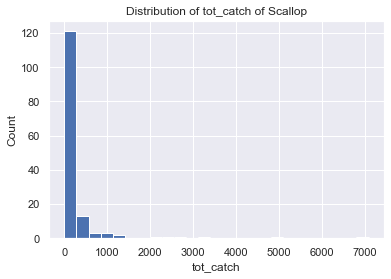

In [3]:
# Histogram of tot.catch
plt.hist(scallop['tot.catch'],bins=25)
plt.xlabel('tot_catch')
plt.ylabel('Count')
plt.title('Distribution of tot_catch of Scallop')
plt.show()

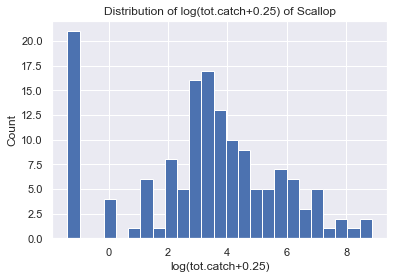

In [4]:
# log(x+0.25) transform of tot.catch (in case of log(0) not defined)
log_y = scallop['tot.catch'].apply(lambda x: np.log(x+0.25))
plt.hist(log_y,bins=25)
plt.xlabel('log(tot.catch+0.25)')
plt.ylabel('Count')
plt.title('Distribution of log(tot.catch+0.25) of Scallop')
plt.show()

## Prepare for the training set and test set

In [5]:
n = scallop.shape[0]
sigma_n = 2.5 # std error of the measurement error

x_train = scallop[['latitude','longitude']].values

# number of training cases
n_train = scallop.shape[0]

# log transformed tot.catch for training set
y_train =  np.log(scallop['tot.catch'].values+0.25)

In [6]:
# generate grid of test points
x_test = np.empty([0,2])
test_x1 = np.arange(min(scallop['latitude'].values),max(scallop['latitude'].values),step=0.1)
test_x2 = np.arange(min(scallop['longitude'].values),max(scallop['longitude'].values),step=0.1)
for i in test_x1:
    for j in test_x2:
        temp = np.array([[i.round(1),j.round(1)]])
        x_test = np.append(x_test,temp,axis=0)

x_test

array([[ 38.6, -73.7],
       [ 38.6, -73.6],
       [ 38.6, -73.5],
       ...,
       [ 40.9, -71.8],
       [ 40.9, -71.7],
       [ 40.9, -71.6]])

## Using Squared Exponential kernel

$\text{cov}(f(x_p), f(x_q)) = \exp\left(-\frac{1}{2} ||x_p - x_q||^2\right)$

In [7]:
def kernel_SE(x1,x2):
    '''
    input: x1, x2 are numpy arrays (each representing a single data point)
    output: the function returns squared exponential
    '''
    return np.exp(-0.5*np.sum((x1-x2)**2))

## Compute covariance matrices

Notation: $K(X, X) \in M_{n\times n}(\mathbb{R})$, $K(X_*, X) \in M_{n_* \times n}(\mathbb{R})$, $K(X_*, X_*) \in M_{n_*\times n_*}(\mathbb{R})$ are the covariance matrices among training data, test data, and training data and test data.

In [8]:
import itertools

def compute_cov_matrices(x, x_star):
    """
    x: training set (2-D array)
    x_star: test set (2-D array)
    
    Follow the notation:
        - K = K(X, X) 
        - K_star_star = K(X_*, X_*)
        - K_star = K(X_*, X)
    """
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_SE(i, j) for (i, j) in itertools.product(x, x)] # iterate every pair of vector in x

    K = np.array(K).reshape(n, n)
    
    K_star_star = [kernel_SE(i, j) for (i, j) in itertools.product(x_star, x_star)]

    K_star_star = np.array(K_star_star).reshape(n_star, n_star)
    
    K_star = [kernel_SE(i, j) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star_star, K_star)

In [9]:
K, K_star_star, K_star = compute_cov_matrices(x_train, x_test)

(148, 148)


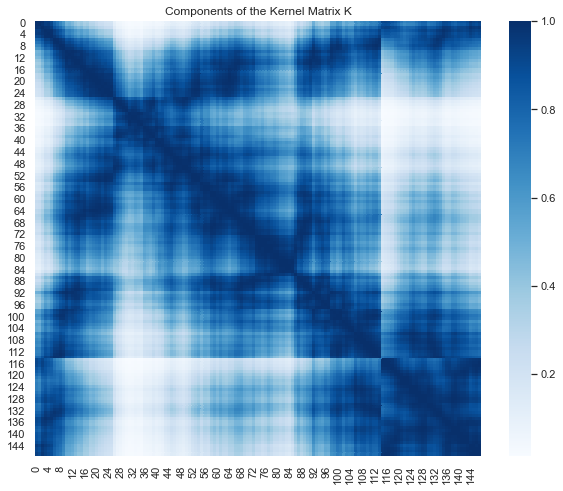

In [10]:
print(K.shape)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K')
plt.show()

(528, 528)


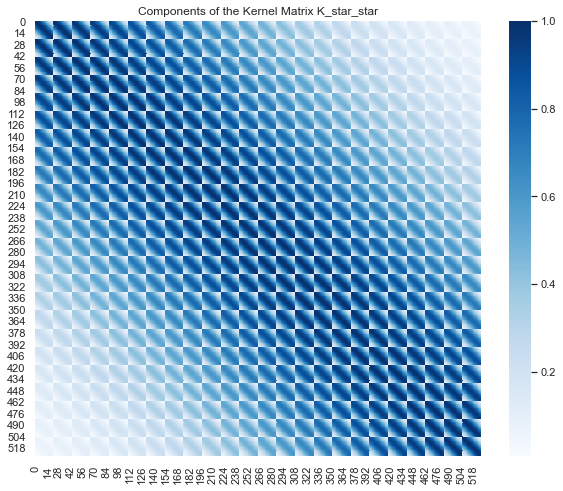

In [11]:
print(K_star_star.shape)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star_star, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star_star')
plt.show()

(528, 148)


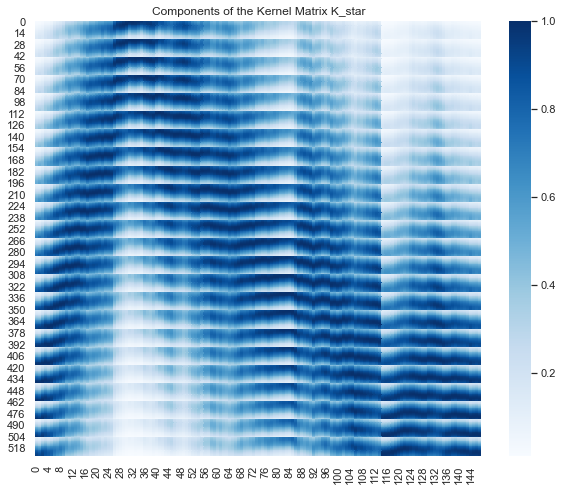

In [12]:
print(K_star.shape)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star')
plt.show()

## Joint distribution

The joint distribution of 
$y$ and $f_*$ is given by $\left(\begin{array}{c}y \\f_*\end{array}\right)\sim N(0, C)$, 
$C = \left(\begin{array}{cc}K(X, X) + \sigma^2_n I & K(X, X_*) \\K(X_*, X) & K(X_*, X_*)\end{array}\right)$ (Noisy observations)

In [13]:
a = np.concatenate((K + (sigma_n**2)*np.eye(n_train), K_star), axis=0)
a.shape

(676, 148)

In [14]:
b = np.concatenate((K_star.T, K_star_star), axis=0)
b.shape

(676, 528)

In [15]:
C = np.concatenate((a, b), axis=1)
C.shape

(676, 676)

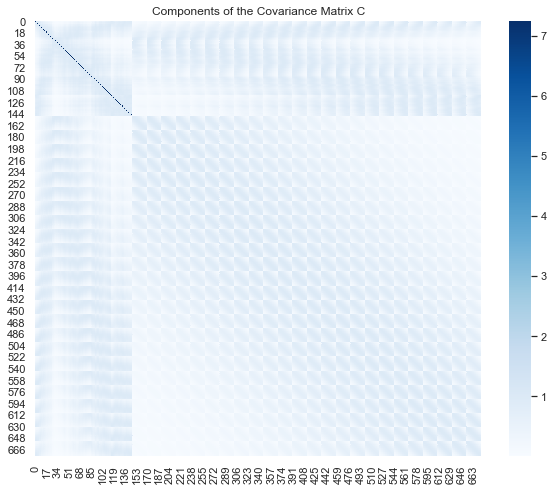

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=C, cmap='Blues', ax=ax)
ax.set(title='Components of the Covariance Matrix C');
plt.show()

## Conditional distribution (Posterior predictive distribution)

$f_*|X, y, X_* \sim N(\bar{f}_*, \text{cov}(f_*))$, 

where $\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y \in \mathbb{R}^{n_*}$ and 

$\text{cov}(f_*) = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*) \in M_{n_*\times n_*}(\mathbb{R})$

In [17]:
def compute_gpr_parameters(K, K_star_star, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""
    
    n = K.shape[0]
    
    # predictive distribution mean
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y_train.reshape([n, 1])))
    
    # predictive distribution covariance
    cov_f_star = K_star_star - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)

In [18]:
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star_star, K_star, sigma_n)

In [19]:
# sample from posterior distribution
z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
count_star = np.exp(z_star) 

In [20]:
df_test = pd.DataFrame(x_test)
df_test.columns=['latitude','longitude']

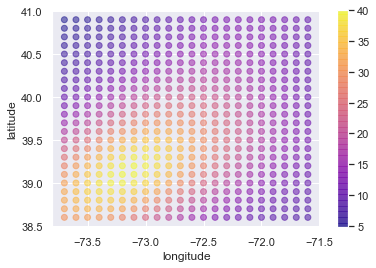

In [21]:
# posterior predictive counts for this given region
plt.scatter(df_test["longitude"], df_test["latitude"], alpha=0.5, c=pd.Series(count_star), cmap='plasma')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

## For reference

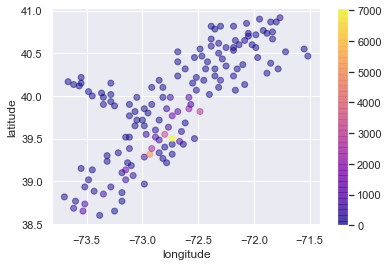

In [22]:
plt.scatter(scallop["longitude"], scallop["latitude"], alpha=0.5, c=scallop['tot.catch'], cmap='plasma')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()